[*********************100%***********************]  1 of 1 completed
Buy at: 18.452856063842773
Sell at: 18.376428604125977
Buy at: 20.04857063293457
Sell at: 19.988929748535156
Buy at: 18.951786041259766
Sell at: 18.898571014404297
Buy at: 18.97857093811035
Sell at: 19.482498168945312
Buy at: 25.532499313354492
Sell at: 25.174999237060547
Buy at: 28.667499542236328
Sell at: 29.904996871948242
Buy at: 29.732500076293945
Sell at: 29.612499237060547
Buy at: 24.087499618530273
Sell at: 23.520000457763672
Buy at: 25.292499542236328
Sell at: 26.604997634887695
Buy at: 26.920000076293945
Sell at: 26.219999313354492
Buy at: 24.912500381469727
Sell at: 24.614999771118164
Buy at: 23.88249969482422
Sell at: 24.560001373291016
Buy at: 29.1299991607666
Sell at: 28.897499084472656
Buy at: 37.182498931884766
Sell at: 38.682498931884766
Buy at: 39.0
Sell at: 40.162498474121094
Buy at: 39.102500915527344
Sell at: 40.52750015258789
Buy at: 43.587501525878906
Sell at: 43.3125
Buy at: 47.970001220703125


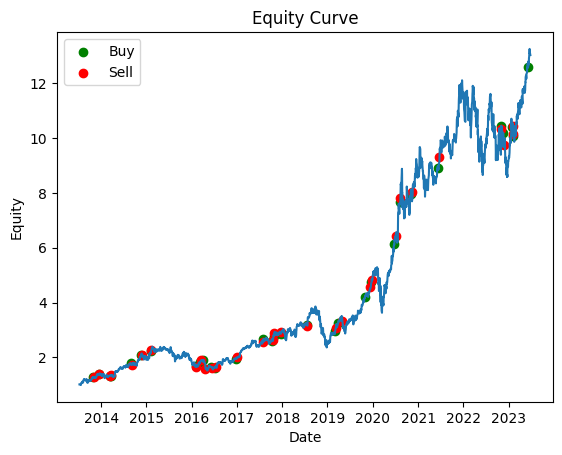

Cumulative Returns: 0.046927772457752724
Maximum Drawdown: -2.955975503594117
Sharpe Ratio: 1.0506705110743746


In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch historical price data using yfinance
ticker = "AAPL"  # Replace with the desired ticker symbol
start_date = "2013-07-09"  # Replace with the desired start date
end_date = "2023-07-09"  # Replace with the desired end date

data = yf.download(ticker, start=start_date, end=end_date)
df = data[['Open', 'High', 'Low', 'Close']].copy()

# Calculate MACD
def calculate_macd(df, short_period=12, long_period=26, signal_period=9):
    df['EMA_short'] = df['Close'].ewm(span=short_period, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_period, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()

calculate_macd(df)

# Identify Double Top pattern
def identify_double_top(df, lookback=5):
    df['High_shifted'] = df['High'].shift(1)
    df['Low_shifted'] = df['Low'].shift(1)
    df['Double_Top'] = ((df['High'] > df['High_shifted']) &
                        (df['High_shifted'] < df['High_shifted'].shift(1)) &
                        (df['Low'] < df['Low_shifted']))
    df.drop(['High_shifted', 'Low_shifted'], axis=1, inplace=True)

identify_double_top(df)

# Implement trading strategy
capital = 100000  # Initial capital
position = 0  # 0 for no position, 1 for long position
stop_loss = 0  # Stop-loss level
take_profit = 0  # Take-profit level
returns = []  # List to track daily returns
buy_dates = []
sell_dates = []

for i in range(1, len(df)):
    # Buy signal
    if df['MACD'].iloc[i] > df['Signal'].iloc[i] and df['Double_Top'].iloc[i]:
        if position == 0:
            position = 1
            stop_loss = df['Low'].iloc[i]
            take_profit = df['High'].iloc[i] + (df['High'].iloc[i] - stop_loss) * 2
            buy_dates.append(df.index[i])
            returns.append(0)  # Add a dummy return value
            print('Buy at:', df['Close'].iloc[i])

    # Sell signal
    elif position == 1 and (df['Low'].iloc[i] < stop_loss or df['High'].iloc[i] > take_profit):
        position = 0
        exit_price = stop_loss if df['Low'].iloc[i] < stop_loss else take_profit
        returns.append((exit_price - df['Close'].iloc[i-1]) / df['Close'].iloc[i-1])
        capital *= (1 + returns[-1])
        sell_dates.append(df.index[i])
        print('Sell at:', exit_price)

    # Hold position
    else:
        returns.append((df['Close'].iloc[i] - df['Close'].iloc[i-1]) / df['Close'].iloc[i-1])

# Remove the dummy return value
returns = returns[1:]

# Calculate evaluation metrics
cumulative_returns = (capital - 100000) / 100000
max_drawdown = np.min(np.subtract.accumulate(returns))
daily_returns = np.array(returns)
sharpe_ratio = np.sqrt(252) * np.mean(daily_returns) / np.std(daily_returns)

# Plot equity curve
equity_curve = np.cumprod(1 + np.array(returns))
plt.plot(df.index[1:len(equity_curve)+1], equity_curve)

buy_indices = np.where(df.index.isin(buy_dates))[0]
sell_indices = np.where(df.index.isin(sell_dates))[0]

# Adjust the sell indices to match the length of the equity curve
sell_indices = sell_indices[sell_indices < len(equity_curve)]

plt.scatter(df.index[buy_indices], equity_curve[buy_indices], color='green', label='Buy')
plt.scatter(df.index[sell_indices], equity_curve[sell_indices], color='red', label='Sell')


plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Curve')
plt.legend()
plt.show()

# Print evaluation metrics
print('Cumulative Returns:', cumulative_returns)
print('Maximum Drawdown:', max_drawdown)
print('Sharpe Ratio:', sharpe_ratio)
